In [1]:
#from wofs_ml_severe.wofs_ml_severe import Classifier
from master.ml_workflow.ml_workflow.calibrated_pipeline_hyperopt_cv import CalibratedPipelineHyperOptCV

import pandas as pd
from os.path import join
import numpy as np
from ml_workflow.ml_workflow.ml_methods import norm_aupdc, brier_skill_score
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp
from glob import glob

In [2]:
known_skew = {'first_hour': {'severe_hail': 0.0391880873707248,
  'severe_wind': 0.027375770765324627,
  'tornado': 0.012250931885049705},
 'second_hour': {'severe_hail': 0.03567197119293762,
  'severe_wind': 0.02379619369012823,
  'tornado': 0.009605216107852312}}

In [3]:
def scorer(model, X, y, known_skew):
    naupdc = []
    bss = [] 
    auc = []
    for n in range(10):
        inds = np.random.choice(len(X), size=len(X))
        X_i = X.iloc[inds, :]
        y_i = y[inds]
        predictions = model.predict_proba(X_i)[:,1]
        naupdc.append(norm_aupdc(y_i, predictions, known_skew=known_skew))
        bss.append(brier_skill_score(y_i, predictions))
        auc.append(roc_auc_score(y_i, predictions))
        
    print( f'NAUPDC: {np.mean(naupdc):.03f} | BSS : {np.mean(bss):.03f} | AUC : {np.mean(auc):.03f}')

In [4]:
def load_ml_data(lead_time = 'first_hour', 
                 mode = 'train',
                 cols_to_drop = ['label', 'obj_centroid_x', 
                                 'obj_centroid_y', 'Run Date', 
                                 'forecast_time_index'], 
                target_col = 'hail_severe_3km_obj_match',
                sanity_check=False 
                ): 
    """ Loads the ML dataset. """
    # Target Var : [tornado|wind|hail]_[severe|sig_severe]_[3km, 9km, 15km, 30km]_[obj_match | ]
    #base_path = '/work/mflora/ML_DATA/MLDATA'
    #file_path = join(base_path, f'wofs_ml_severe__{lead_time}__{mode}_data.feather')
    
    if sanity_check:
        base_path = '/work/mflora/ML_DATA/DATA'
        file_path = join(base_path, f'wofs_ml_severe__{lead_time}__data.feather')
    else:
        base_path = '/work/mflora/ML_DATA/MLDATA'
        file_path = join(base_path, f'wofs_ml_severe__{lead_time}__{mode}_data.feather')
        
    df = pd.read_feather(file_path)

    metadata = df[['Run Date', 'forecast_time_index', 'Initialization Time', 'label']]
    index = list(df.columns).index('hail_severe_3km_obj_match')
    possible_features = list(df.columns)[:index]

    drop_vars = ['QVAPOR', 'freezing_level', 'stp', 'okubo_weiss', 'Initialization Time', 
                 'qv_2', 'srh_0to500'
                ]
    
    features = [f for f in possible_features if f not in cols_to_drop]
    
    if sanity_check:
        features = [f for f in features if not any([d in f for d in drop_vars])]
    
    X = df[features]
    y = df[target_col]

    return X,y, metadata 

In [5]:
def load_original_data(target, mode='training'):
    
    target = f'matched_to_{target}_0km'
    
    df = pd.read_feather(
    f'/work/mflora/ML_DATA/DATA/original_first_hour_{mode}_{target}_data.feather')
    
    metadata = ['label', 'Run Time', 'Run Date', 'FCST_TIME_IDX']
    targets = ['matched_to_severe_hail_0km',
     'matched_to_severe_hail_15km',
     'matched_to_LSRs_0km',
     'matched_to_LSRs_15km',
     'matched_to_severe_wind_0km',
     'matched_to_severe_wind_15km',
     'matched_to_tornado_0km',
     'matched_to_tornado_15km']
    features = [f for f in df.columns if f not in targets+metadata]

    X = df[features].astype(float)
    y = df[target].astype(float).values
    
    dates = df['Run Date'].apply(str)
    
    return X, y, dates

In [6]:
# Convert New to Old 
def convert(X, y, new_dates, old_dates):
    # Get the indices of dates within the old dates 
    cond = new_dates.isin(np.unique(old_dates))
    
    inds = np.where(cond==True)[0]
    
    X = X.iloc[inds]
    y = y[inds]
    new_dates = new_dates[inds]
    
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    new_dates.reset_index(drop=True, inplace=True)
    
    return X, y, new_dates

In [7]:
# Load the original training and testing dataset. 
target = 'severe_wind'
target_col = 'wind_severe_3km'

use_new_data = True

X_train, y_train, train_dates = load_original_data(mode='training', target=target)
X_test, y_test, test_dates = load_original_data(mode='testing', target=target)

if use_new_data:
    X, y, metadata = load_ml_data(target_col=target_col, 
                                   lead_time = 'first_hour', mode = None, sanity_check=True )
    all_dates = metadata['Run Date'].apply(str)
    X_train, y_train, train_dates = convert(X, y, all_dates, train_dates)
    X_test, y_test, test_dates = convert(X, y, all_dates, train_dates)

In [8]:
correct_dbz = True

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

if correct_dbz:
    dbz_vars = [c for c in X_train.columns if 'dbz' in c and 'ens_mean' in c]
    drop_vars = [c for c in X_train.columns if 'dbz' in c and 'std' in c]
    keep_vars = [c for c in X_train.columns if c not in drop_vars]

    X_train = X_train[keep_vars]

    # Set the negative dbz values to zero. 
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    for c in dbz_vars:
        train_vals = X_train[c].values
        X_train_copy[c] = np.where(train_vals<0, 0, train_vals)
        test_vals = X_test[c].values
        X_test_copy[c] = np.where(test_vals<0, 0, test_vals)

In [9]:
scaler = 'standard'
model_name = 'LogisticRegression'
lead_time = 'first_hour'

paths = glob(f'/work/mflora/ML_DATA/MODEL_SAVES/{model_name}_{lead_time}_{target}*')
path = [p for p in paths if 'manual' not in p][0]    

resample = None if 'None' in path else 'under'

if use_new_data:
    save_name = join('/work/mflora/ML_DATA/new_models/', 
                 f'new_{model_name}_{lead_time}_{target}_{resample}_{scaler}_.pkl')
else:
    save_name = join('/work/mflora/ML_DATA/new_models/', 
                 f'{model_name}_{lead_time}_{target}_{resample}_{scaler}_.pkl')

#clf_fitted = clf.fit(model_name, X_train, y_train, new_train_dates, 
#                     categorical_features=categorical_features, max_iter=20, scaler='standard', n_jobs=5, 
#                    save_name=save_name, params={'C': 0.7, 'l1_ratio': 0.2})

if model_name == 'LogisticRegression':
    base_estimator = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=300, random_state=42)
else:
    base_estimator = RandomForestClassifier(n_jobs = n_jobs, criterion='entropy', random_state=42)
    
    
if 'Random' in model_name:
    #RandomForest Grid
    param_grid = {
               'n_estimators': hp.choice('n_estimators', [100,250,300,500, 750, 1000]),
               'max_depth': hp.choice('max_depth', [3, 5, 8, 10, 15, 20,]),
               'max_features' : hp.choice( 'max_features', [5,6,8,10, 'sqrt']),
               'min_samples_split' : hp.choice( 'min_samples_split', [4,5,8,10,15,20,25,50] ),
               'min_samples_leaf': hp.choice( 'min_samples_leaf', [4,5,8,10,15,20,25,50]),

               }   
else:
    param_grid = {
                'l1_ratio': hp.choice('l1_ratio', [0.0001, 0.001, 0.01, 0.1, 0.5, 0.6, 0.8, 1.0]),
                'C': hp.choice('C', [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0]),
                }
    
clf = CalibratedPipelineHyperOptCV(base_estimator=base_estimator, param_grid=param_grid, 
                                   scaler=scaler, 
                                   resample=resample, n_jobs=5, max_iter=40, 
                                   cv_kwargs = {'dates': train_dates, 'n_splits': 5, 'valid_size' : 20} )

clf.fit(X_train_copy, y_train)# params = {'C' : 0.01, 'l1_ratio' : 1.0})
clf.save(save_name)

  0%|                                                                                                                                                                                                               | 0/100 [00:00<?, ?trial/s, best loss=?]

/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)

/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)

/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)



 42%|███████████████████████████████████████████████████████████████████████████▌                                                                                                        | 42/100 [09:36<13:15, 13.72s/trial, best loss: 0.7786557404799371]


In [10]:
# Test score
X_test_copy = X_test_copy[X_train_copy.columns]
scorer(clf, X_test_copy, y_test, np.mean(y_train))

NAUPDC: 0.372 | BSS : 0.241 | AUC : 0.945


In [11]:
# Train Score
scorer(clf, X_train_copy, y_train, np.mean(y_train))

NAUPDC: 0.371 | BSS : 0.241 | AUC : 0.945


In [21]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_pred = clf.predict_proba(X_test_copy)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
sr, pod, _ = precision_recall_curve(y_test, y_pred)

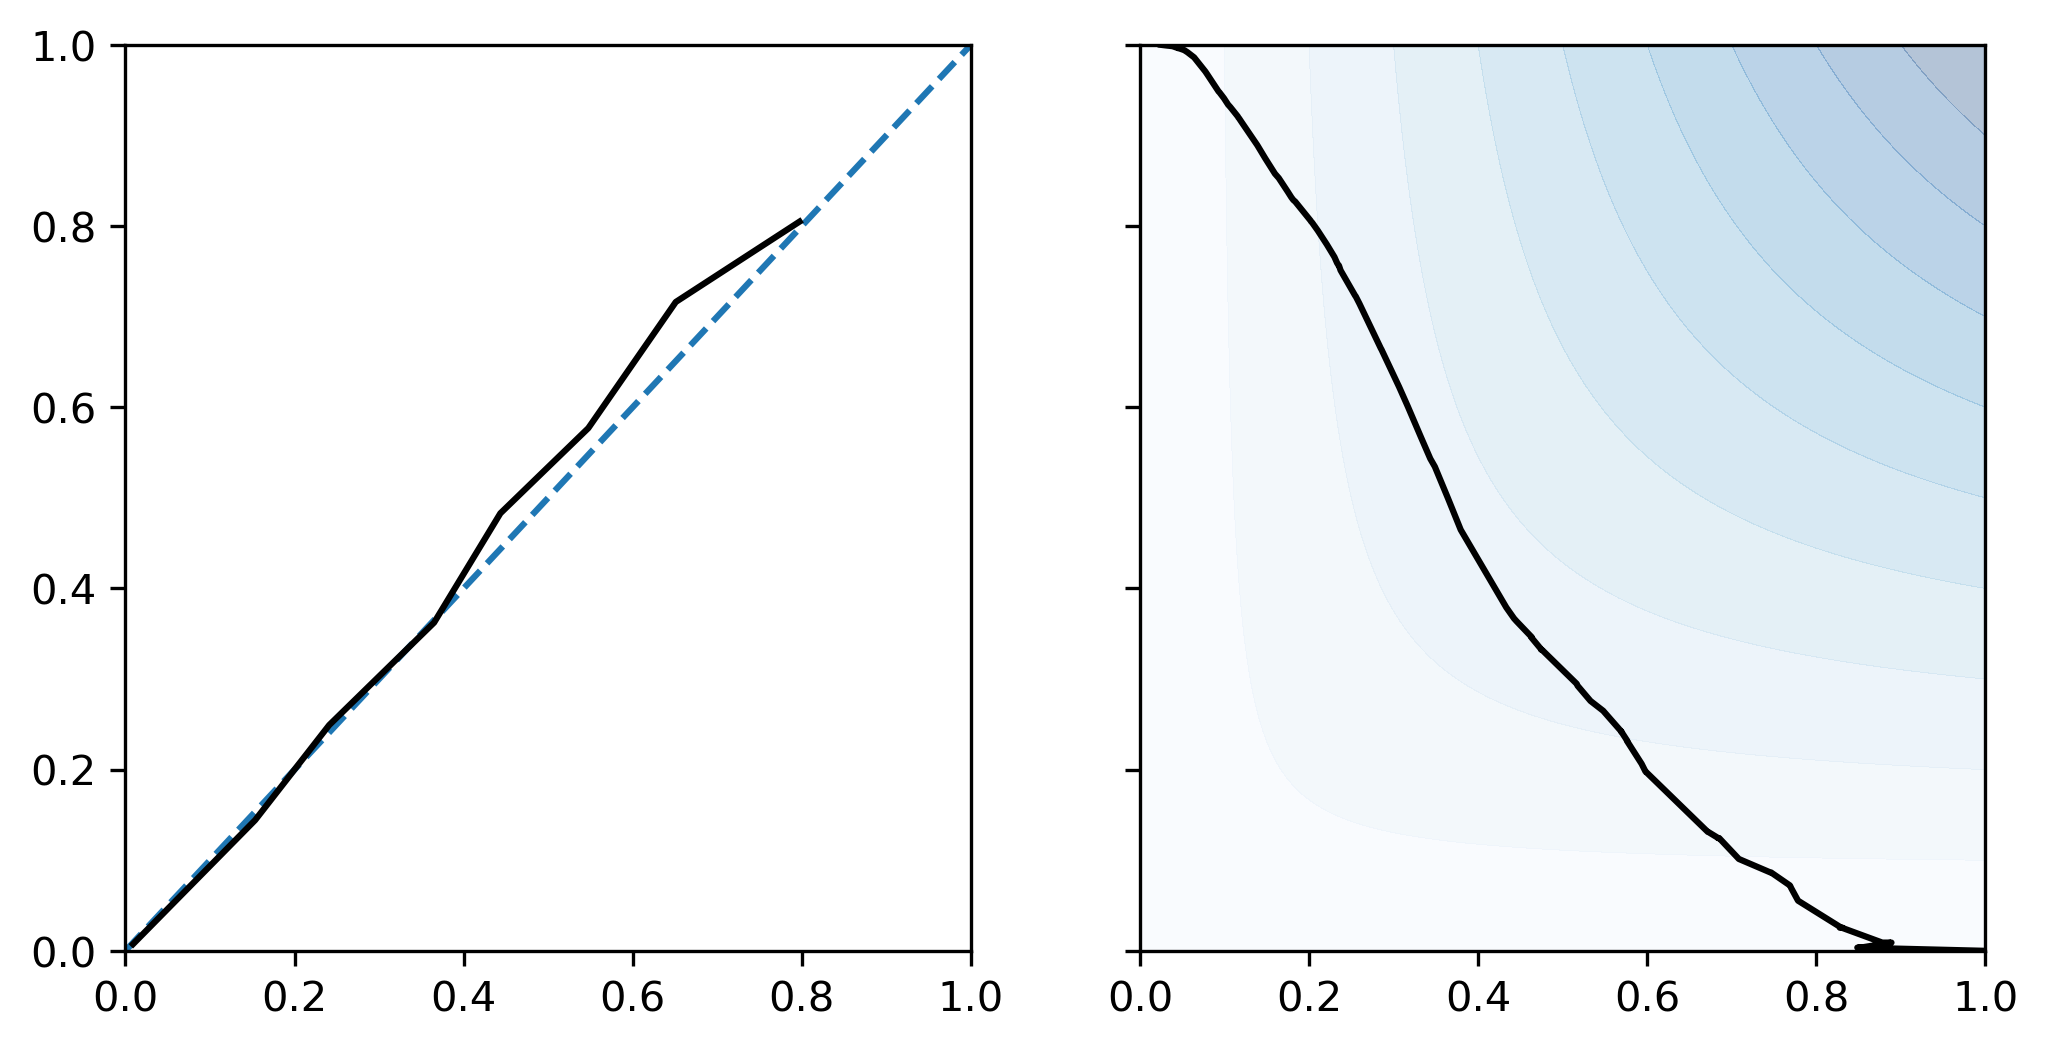

In [22]:
f, axes = plt.subplots(ncols=2, dpi=300, sharey=True, figsize=(8,4))

for i, (ax, x, y) in enumerate(zip(axes.flat, [prob_pred, sr], [prob_true, pod])):
    
    prob_true[(prob_true < 0.00001) & (prob_pred > 0)] = np.nan
    
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    if i == 0:
        ax.plot([0,1], [0,1], ls='dashed')
    else:
        xx = np.linspace(0,1,100)
        yy = xx
        xx,yy = np.meshgrid(xx,xx)
        csi = 1 / (1/xx + 1/yy -1)
        ax.contourf(xx,yy,csi, cmap='Blues', alpha=0.3, levels=np.arange(0,1.1,0.1))
        
    ax.plot(x,y, color='k')

plt.savefig(f'{model_name}_{lead_time}_target.png')